# Biological data analysis


Fill in your name:

Evaluation:

- Comments
- Applied methods
- Figures
- Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re
import scipy.signal as signal
import scipy.stats as stats
sns.set()

---
>> **TASK**
>>
>> 1. Detect eye movements (EOG)
>>
>> Recording files in EOG folder xEOG.csv where x is the subject number.
>>
>> First column - EOG vertical electrodes (V)
>>
>> Second column - EOG horizontal electrodes (V)
>>
>> Third column - time (ms)
>>
>> - Clean data, write function for multi-subject analysis automation.
>> - Detect vertical eye movement.
>> - Detect horizontal eye movement.
>> - Calculate EOG parameters (average amplitude, Inter peak time, eye blink frequency), organize, plot and export to csv file.
>> - Plot average horizontal and vertical eye blink for each subject.
>> - Plot grand average horizontal and vertical eye blink (across all
>>   subjects).
>>
>> More on EOG:
>>
>> https://en.wikipedia.org/wiki/Electrooculography
>>
>> EOG.pdf describes in detail EOG detection and general EOG morphology.
>> The task and solutions are a lot more simple then presented in the article.
>>
---

## Data exploration

In [2]:
EOGdata = pd.read_csv("./EOG/1EOG.csv", names=["EOGv", "EOGh", "time"])
EOGdata.head()

,EOGv,EOGh,time
0,43.549,41.240,0.00000
1,39.616,34.253,0.48828
2,36.466,33.116,0.97656
3,35.722,37.133,1.46480
4,32.839,37.292,1.95310


In [3]:
fs = int(round(EOGdata["time"].shape[0] / EOGdata["time"].iloc[-1] * 1000))
fs

2048

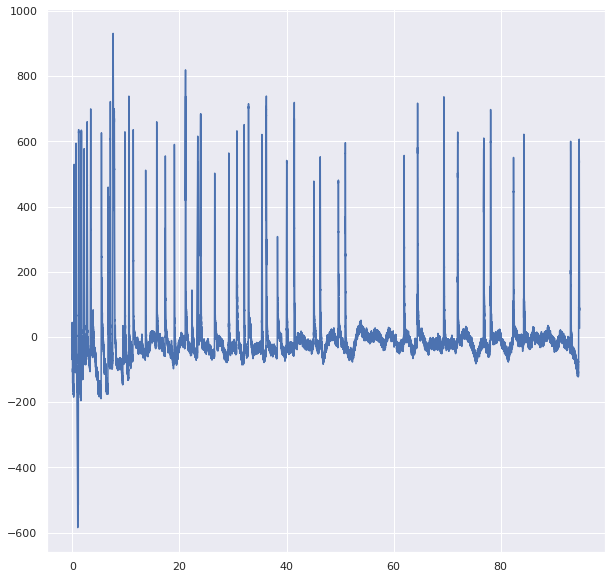

In [4]:
plt.figure(figsize=(10, 10))
plt.plot(EOGdata["time"] / fs, EOGdata["EOGv"]);

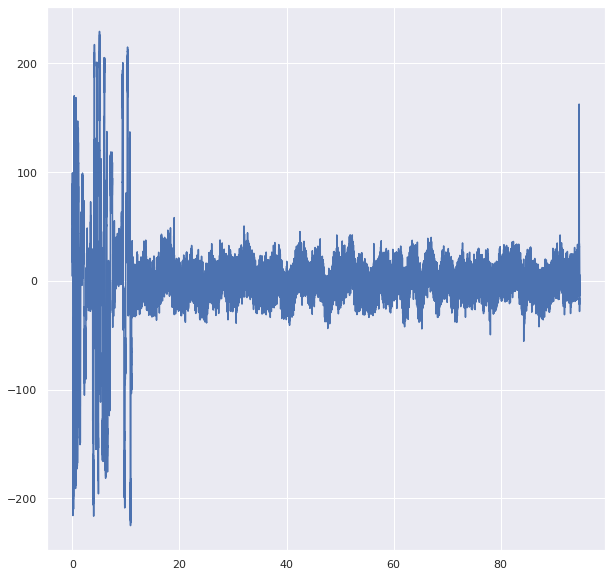

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(EOGdata["time"] / fs, EOGdata["EOGh"]);

Function for reading

In [6]:
def readEOG(filename):
  data = pd.read_csv(filename, names=["EOGv", "EOGh", "time"])
  fs = int(round(data["time"].shape[0] / data["time"].iloc[-1] * 1000))
  return data, fs

Peak extraction

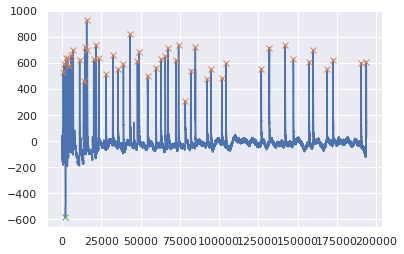

In [7]:
peaks_v, peak_prop_v = signal.find_peaks(
    EOGdata["EOGv"],
    height=(200, None),
    distance=800,
    prominence=(None, None),
    width=None,
    wlen=(600),
)

peaks_v2, peak_prop_v2 = signal.find_peaks(
    EOGdata["EOGv"] * -1,
    height=(200, None),
    distance=800,
    prominence=(None, None),
    width=None,
    wlen=(600),
)
fig = plt.figure()
ax = plt.axes()
ax.plot(EOGdata["time"], EOGdata["EOGv"])
ax.plot(peaks_v / fs * 1000, EOGdata["EOGv"][peaks_v], "x")
ax.plot(peaks_v2 / fs * 1000, EOGdata["EOGv"][peaks_v2], "x");

Function for peak extraction

In [48]:
def get_blinks(data):
  peaks_v, peak_prop_v = signal.find_peaks(
      data["EOGv"],
      height=(200, None),
      distance=800,
      prominence=(None, None),
      width=None,
      wlen=(600),
  )
# peaks_v2, peak_prop_v2 = signal.find_peaks(
#     data["EOGv"] * -1,
#     height=(200, None),
#     distance=800,
#     prominence=(None, None),
#     width=None,
#     wlen=(600),
# )
  pikai = pd.concat(
      [
          pd.DataFrame({**peak_prop_v, "index": peaks_v}),
#          pd.DataFrame({**peak_prop_v2, "index": peaks_v2}),
      ]
  )
  return pikai

Saccade

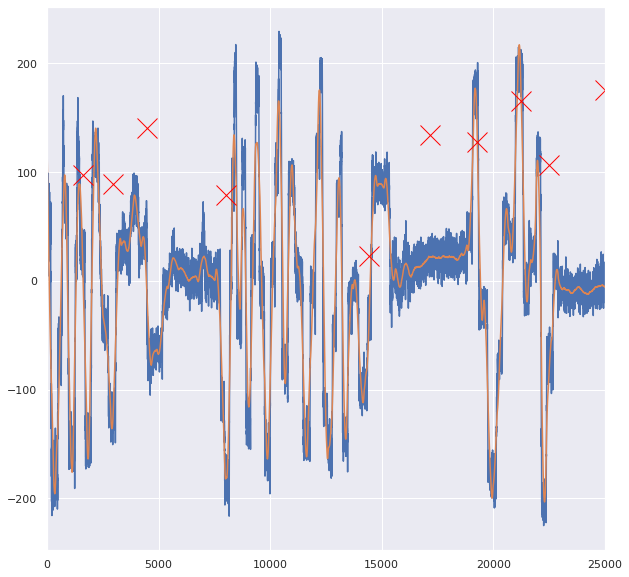

In [49]:
def get_saccade(data):
  x_filtered = signal.savgol_filter(data["EOGh"].values,1001, 2)
  peaks_h, peak_prop_h = signal.find_peaks(
      x_filtered,
      #  wlen=10,
      prominence=(100, 1000),
      width=100,
      #  distance=10,
      #  plateau_size=100
  )
  return pd.concat([pd.DataFrame({**peak_prop_h, "index": peaks_h})]), x_filtered

saccades, x_filtered = get_saccade(EOGdata)

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(EOGdata["time"], EOGdata["EOGh"])
ax.plot(EOGdata["time"], x_filtered)
ax.plot(saccades["index"] / fs * 1000, x_filtered[saccades["index"]], "x", color="red", markersize=20);
ax.set_xlim(0, 25000);

### Average amplitude

NumPy

In [50]:
peaks_prop_v = np.concatenate(
    (peak_prop_v["peak_heights"], peak_prop_v2["peak_heights"])
)
np.mean(peaks_prop_v)

621.7723404255319

Pandas

In [52]:
blinks = get_blinks(EOGdata)
blinks["peak_heights"].mean()

622.578043478261

### Inter peak time

In [53]:
blinks['index'].sort_values().diff().mean()/fs

8.789355555555556

In [54]:
len(EOGdata)/fs/len(blinks)

8.636673913043477

### Blink frequency

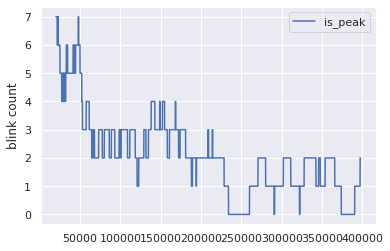

In [55]:
blinks["is_peak"] = 1
data = pd.merge(EOGdata.reset_index(), blinks, how="left", on="index")
data.fillna(0).rolling(fs*20).sum().plot(y="is_peak")
plt.ylabel('blink count');

In [15]:
1/(blinks['index'].sort_values().diff().mean()/fs)

0.23300911961691034

### Average blink

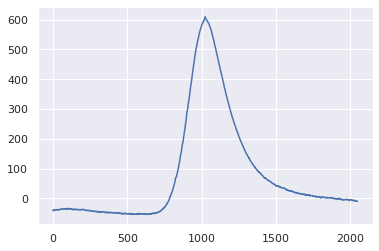

In [16]:
def get_erp(dat, blk, fs):
  edges = int(fs * 0.5)
  avgblink = np.zeros((len(blk),2*edges))
  for idx, blink in enumerate(blk["index"]):
    if blink+edges > len(dat):
      continue
    elif blink-edges < 0:
      continue
    else:
      avgblink[idx,:]=(dat['EOGv'][blink-edges:blink+edges].values)
  avgblink=np.array(avgblink).mean(axis=0)
  return avgblink

plt.plot(get_erp(EOGdata,blinks, fs));

In [17]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

### Loop

EOG/13EOG.csv
EOG/11EOG.csv
EOG/10EOG.csv
EOG/8EOG.csv
EOG/1EOG.csv
EOG/14EOG.csv
EOG/2EOG.csv
EOG/18EOG.csv
EOG/3EOG.csv
EOG/6EOG.csv
EOG/12EOG.csv
EOG/4EOG.csv
EOG/16EOG.csv
EOG/9EOG.csv
EOG/17EOG.csv
EOG/7EOG.csv
EOG/15EOG.csv
EOG/5EOG.csv


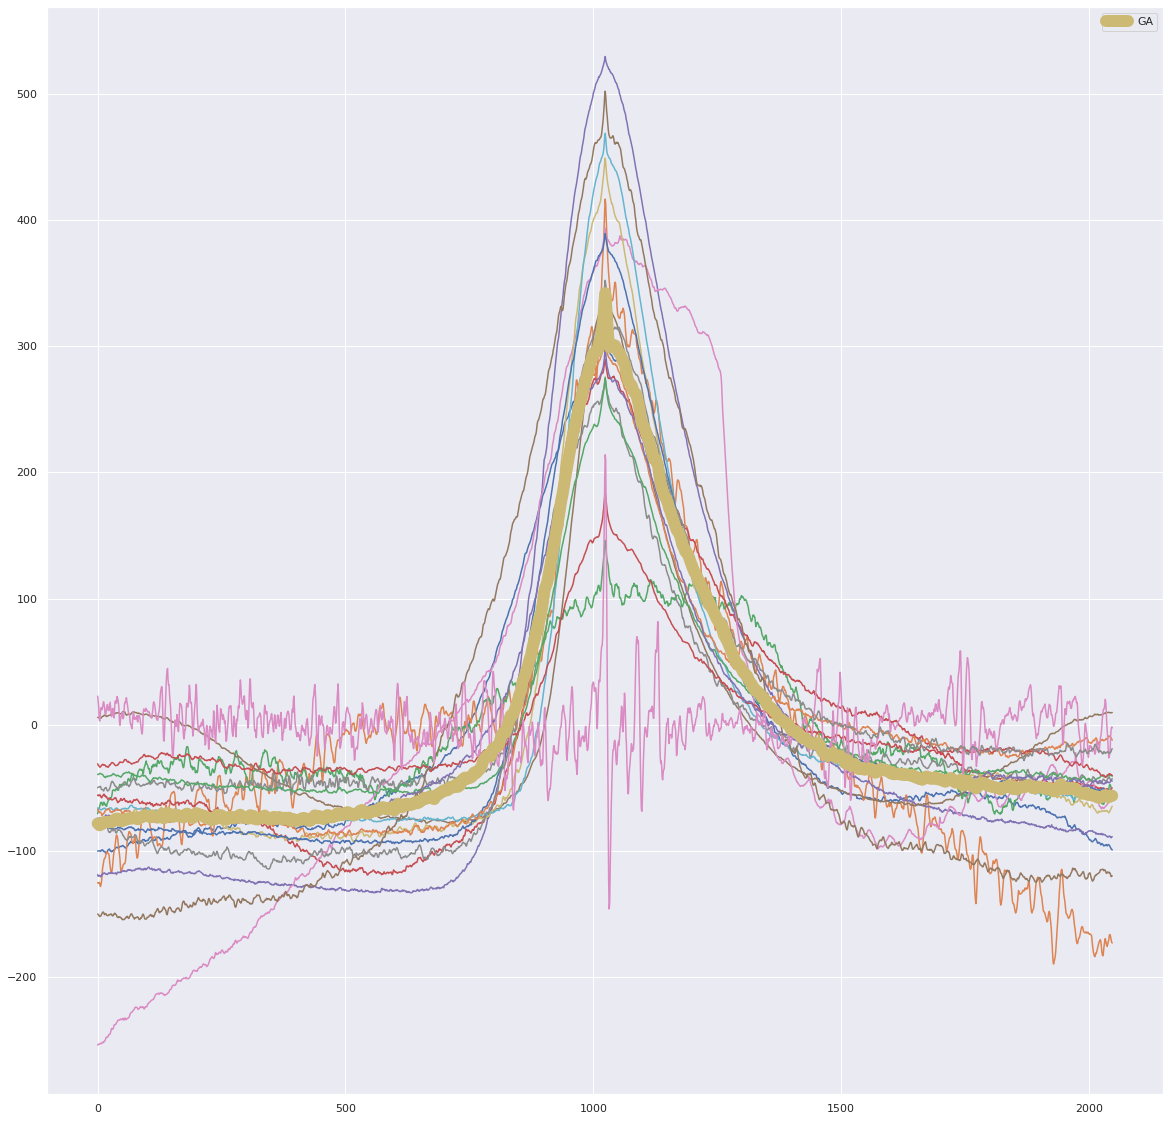

In [19]:
files = list(pathlib.Path('./EOG/').glob('*'))
mean_blink_amplitude = []
mean_inter_blink_time = []
rolling_blink_count = []
avgblinks=[]
avgsaccade=[]
for ifile in files:
  data, fs = readEOG(ifile)
  print(ifile)
#  data['EOGv'] = butter_bandpass_filter(data['EOGv'], 1, 50, fs, order=2)
#  data.plot(x='time',y='EOGv')
  blinks = get_blinks(data)
  mean_blink_amplitude.append(blinks['peak_heights'].mean())
  mean_inter_blink_time.append(blinks['index'].sort_values().diff().mean()/fs)
  blinks["is_peak"] = 1
  df = pd.merge(data.reset_index(), blinks, how="left", on="index").fillna(0)
  rolling_blink_count.append(df.rolling(fs*20).sum()['is_peak'].fillna(0).values)
  if len(blinks)>0:
    avgblinks.append(get_erp(data,blinks,fs))
  else:
    avgblinks.append(np.zeros(fs))
  saccades, _= get_saccade(data)
  if len(saccades)>0:
    avgsaccade.append(get_erp(data,saccades,fs))
  else:
    avgsaccade.append(np.zeros(fs))

avgblinks_df = pd.DataFrame(np.array(avgblinks).T,columns=[fl.stem for fl in files]).apply(lambda x: x-x.mean())
plt.figure(figsize=(20,20))
plt.plot(avgblinks_df)
plt.plot(avgblinks_df.mean(axis='columns'), label='GA',linewidth=12)
plt.legend();

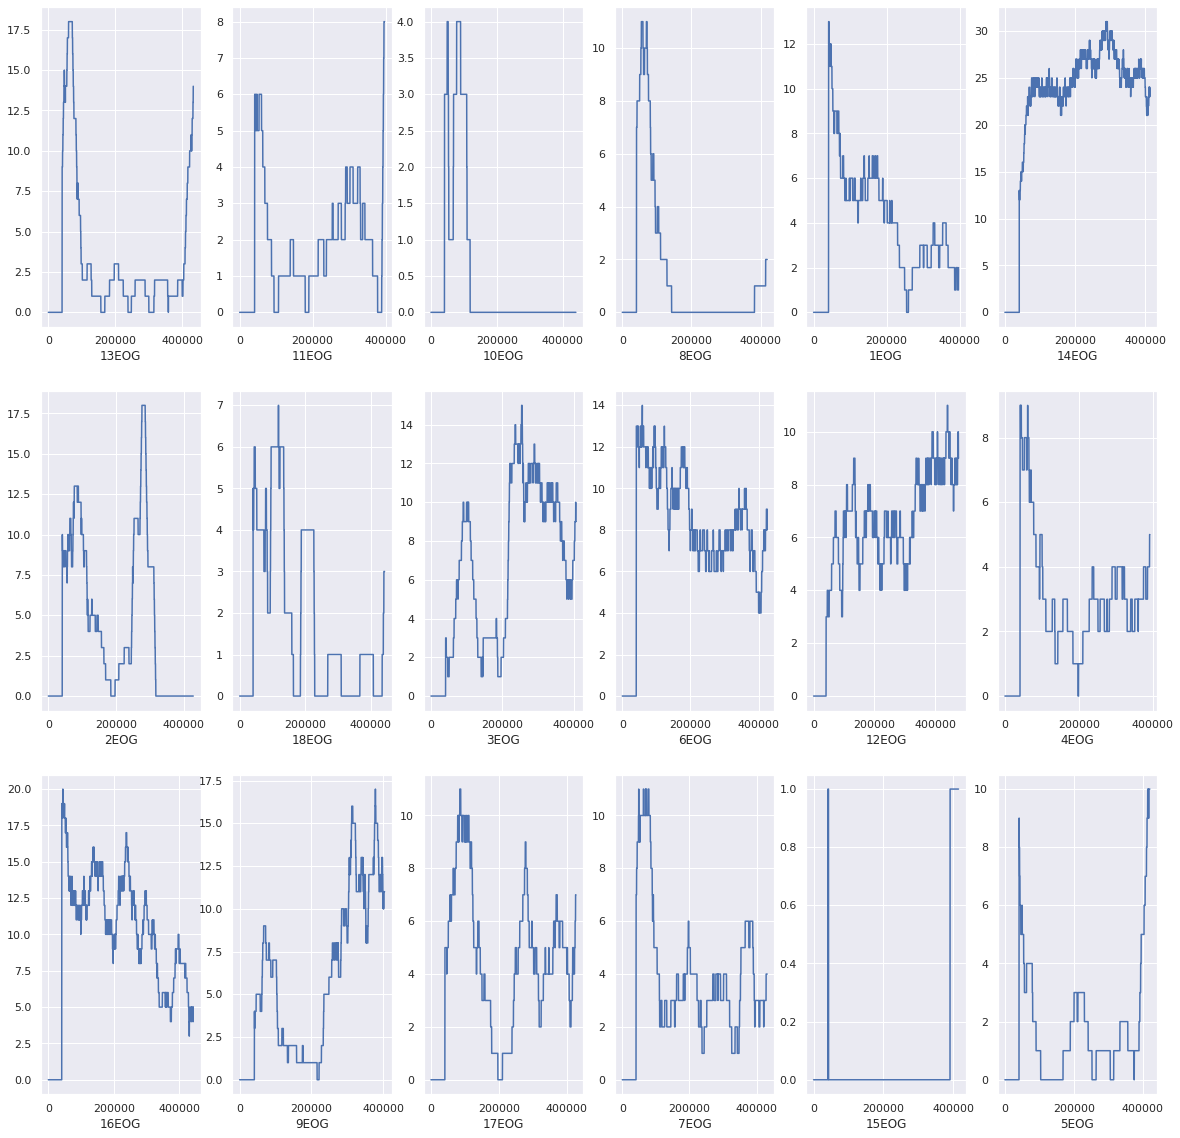

In [20]:
fig, ax = plt.subplots(3, 6,figsize=(20,20))
ax=np.ravel(ax)
for idx,irow in enumerate(rolling_blink_count):
  ax[idx].plot(irow)
  ax[idx].set_xlabel(files[idx].stem)

---
>> **TASK**
>>
>> 2. Waveform shape analysis
>>
>> Electrocorticography (ECoG) performed on rats during auditory stimulation of
>> 40 Hz.
>>
>> <img src="RATecog.jpg" alt="" width="200" height="200">
>>
>> Genetically modified schizophrenic rats response to auditory stimulation tested.
>> Data from rats left auditory channel (Al column) given in folder ECOG.
>> Around 100 stimuli were presented to each rat.
>> Data segmented into epochs (epoch column) -700 to 1200 ms (time column) around stimulus.
>>
>> - Pre-process data. Calculate average response to stimulus and its time
>>   frequency response.
>> - Compare wavelet time frequency response results with filter-hilbert method.
>> First apply filter around stimulation and then calculate analytical signal with hilbert.
>> - Compare methods capturing waveshape dynamics of ECoG during stimulation (0-500 ms)
>>   and baseline period (-600 -100) (Fractal dimension, turn/zerocross count,
>>   RMS)
>> - Plot all results
>>
---

Import data

In [21]:
def readECOG(filename):
  data = pd.read_csv(filename,skiprows=1, names=["index", "time", "condition", "epoch","Al"])
  fs = abs(int(round((data["time"][0] - data["time"][1]) * 1000)))
  return data, fs

In [22]:
files = list(pathlib.Path('./ECOG/').glob('*.csv'))
files

[PosixPath('ECOG/rat-92-oil-CNQX-saline-baseline.csv'),
 PosixPath('ECOG/rat-92-oil-CNQX-saline-test.csv'),
 PosixPath('ECOG/rat-96-oil-MK-CNQX-test.csv'),
 PosixPath('ECOG/rat-96-oil-MK-CNQX-baseline.csv')]

Average response to stimulus

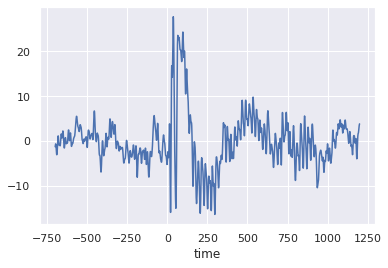

In [23]:
data ,fs = readECOG(files[0])
erp = data.groupby('time')['Al'].mean()
data.groupby('time')['Al'].mean().plot();

Time frequency response

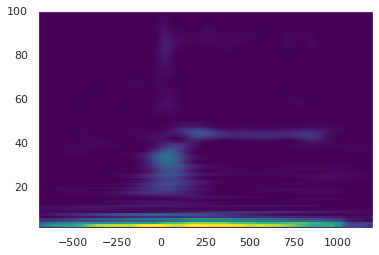

In [24]:
freq = np.linspace(1, fs/2, 500)
w = 20
widths = w * (fs) / (2 * freq * np.pi)
cwtm=np.abs(signal.cwt(erp, signal.morlet2, widths, w=w))**2
cwtm_base = np.mean(cwtm[:,0:900],axis=1)
plt.pcolormesh(erp.index, freq, cwtm, cmap="viridis")
plt.ylim(1,100);

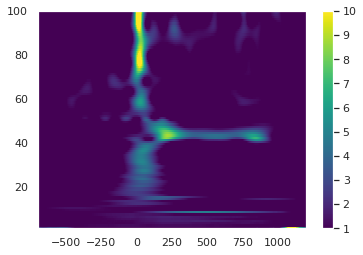

In [25]:
freq = np.linspace(1, fs/2, 500)
w = 20
widths = w * (fs) / (2 * freq * np.pi)
cwtm=np.abs(signal.cwt(erp, signal.morlet2, widths, w=w))**2
cwtm_base = np.mean(cwtm[:,0:900],axis=1)
plt.pcolormesh(erp.index, freq, cwtm/np.expand_dims(cwtm_base,axis=1), cmap="viridis")
plt.ylim(1,100);
plt.clim(1,10);
plt.colorbar();

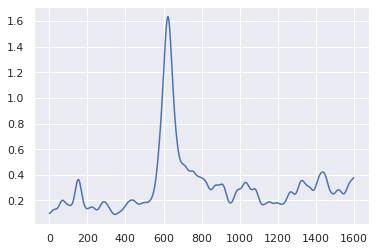

In [26]:
plt.plot((cwtm/np.expand_dims(cwtm_base,axis=1))[:,100:1700].mean(axis=0));

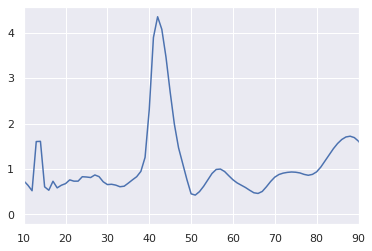

In [27]:
plt.plot((cwtm/np.expand_dims(cwtm_base,axis=1))[:,700:1700].mean(axis=1))
plt.xlim(10,90);

### Filter-Hilbert

In [28]:
def filt_hilb(data, c=40):
  erp_filtered = butter_bandpass_filter(data, c-1, c+1, fs, order=2)
  hilb_signal = abs(signal.hilbert(erp_filtered))**2
  return hilb_signal

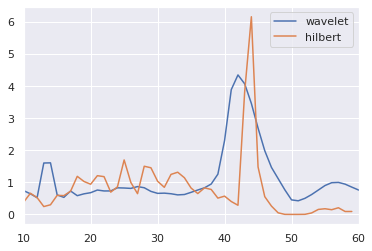

In [29]:
frequencies=np.arange(10,60,1)
erp_hb = np.zeros((len(frequencies), len(erp)))
for idx, ifreq in enumerate(frequencies):
  erp_hb[idx,:]=filt_hilb(erp.values,ifreq)

plt.figure()
plt.plot((cwtm/np.expand_dims(cwtm_base,axis=1))[:,700:1700].mean(axis=1),label='wavelet')
plt.xlim(10,60)
plt.plot(frequencies,erp_hb[:,700:1700].mean(axis=1),label='hilbert')
plt.legend();

### Fractal dimension

In [30]:
def get_FD_Petrosian(data):
  diff=np.ediff1d(data)
  n=len(data)
  N_delta = (diff[1:-1] * diff[0:-2] < 0).sum()
  return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))
  
def higuchi_fd(x, kmax=20):
    x = np.array(x)
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = np.floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = np.log10(1.0 / k)
        y_reg[k - 1] = np.log10(m_lm)
    higuchi, _ = np.polyfit(x_reg, y_reg,1)
    return higuchi

In [31]:
get_FD_Petrosian(erp)

1.0068406419883595

In [32]:
get_FD_Petrosian(erp.loc[-500: -100].values)

1.008347616575563

In [33]:
get_FD_Petrosian(erp.loc[100: 500].values)

1.0091514379922377

In [34]:
higuchi_fd(erp)

1.4480692056135207

In [35]:
higuchi_fd(erp.loc[-500: -100].values)

1.5368053251765297

In [36]:
higuchi_fd(erp.loc[100: 500].values)

1.498039279186827

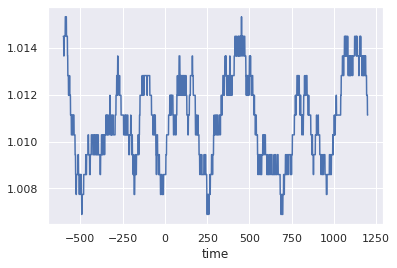

In [37]:
erp.rolling(100).agg(get_FD_Petrosian).plot();

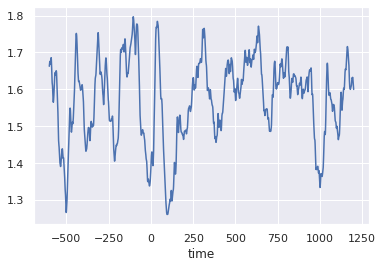

In [38]:
erp.rolling(100).agg(higuchi_fd).plot();

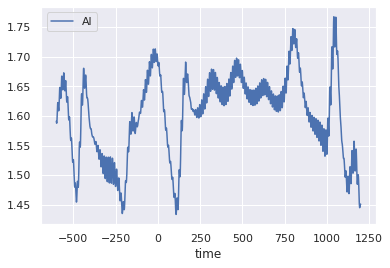

In [39]:
erp_filtered = butter_bandpass_filter(erp, 42-5, 42+5, fs, order=2)
erp_filtered = pd.DataFrame(erp_filtered, columns=['Al'], index=erp.index)
erp_filtered.rolling(100).agg(higuchi_fd).plot();

### Zero crossings

In [40]:
def ZCR2(x, threshold=1E-10):
    _x = np.array(x.copy())
    _x = _x - np.mean(_x)
    _x[np.abs(_x) < threshold] = 0
    sgn = np.sign(_x)
    cross = np.diff((sgn == 0).astype(np.int64))
    count = np.sum((cross) > 0)
    zer = sgn[1:] * sgn[:-1] < 0
    count += np.sum(zer)
    return count

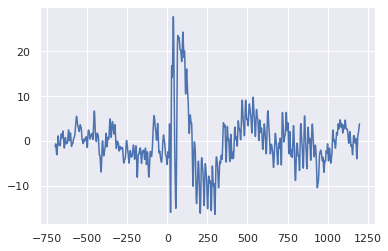

In [41]:
plt.plot(erp);

In [42]:
ZCR2(erp.loc[-500: -100].values)

18

In [43]:
ZCR2(erp.loc[100: 500].values)

10

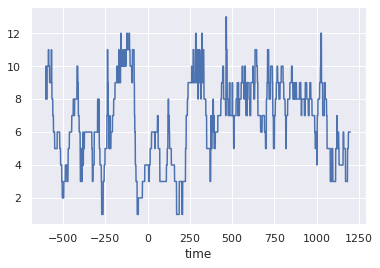

In [44]:
erp.rolling(100).agg(ZCR2).plot();

### RMS

In [45]:
def RMS(data):
  data = np.array(data)
  return np.sqrt(np.mean(data ** 2))

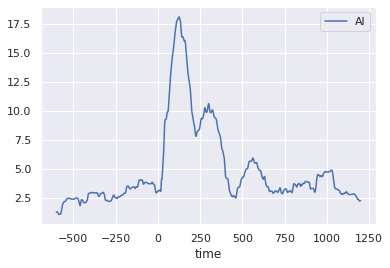

In [46]:
pd.DataFrame(erp).rolling(100).agg(RMS).plot();

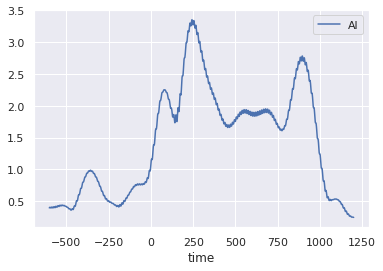

In [47]:
pd.DataFrame(erp_filtered).rolling(100).agg(RMS).plot();